<a href="https://colab.research.google.com/github/sytrinh/digit_recognition_mnist/blob/main/FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will train a model to correctly identify digits from 0 to 9 using the MNIST dataset. The model consists of fully connected layers and is trained using:
1. Keras
2. Only TensorFlow

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


## Understand and preprocess the data

In [ ]:

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
unique_labels = np.unique(train_labels)

print('Training set shape: {}'.format(train_images.shape))
print('Test set shape: {}'.format(test_images.shape))
print('Number of images in training set: {}'.format(train_images.shape[0]))
print('Number of images in test set: {}'.format(test_images.shape[0]))
print('Image size: {}'.format(train_images.shape[1:]))
print('Unique labels: {}'.format(unique_labels))
print('Number of unique labels: {}'.format(len(np.unique(train_labels))))

Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)
Number of images in training set: 60000
Number of images in test set: 10000
Image size: (28, 28)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of unique labels: 10


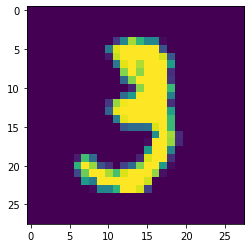

Corresponding label: 3


In [ ]:
img_idx = 10
image = train_images[img_idx]
plt.imshow(image)
plt.show()

print('Corresponding label: {}'.format(train_labels[img_idx]))

Since we're going to use a neural network with fully connected layers (FCL), images need to be reshaped to become a 1D array. As a result, training set will become a 2D array of size `(examples, width*height)`. We should also scale the data so that all values are in the `[0,1]` interval. 

In [ ]:
x_train = train_images.reshape((train_images.shape[0], -1))
x_train = x_train.astype("float32") / 255
x_test = test_images.reshape((test_images.shape[0], -1))
x_test = x_test.astype("float32") / 255

print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))

x_train shape: (60000, 784)
x_test shape: (10000, 784)


In [ ]:
y_train = train_labels
y_test = test_labels

## Train a model using Keras

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

model = keras.Sequential([
                          layers.Dense(512, activation='relu'),
                          layers.Dense(10, activation='softmax')])

optimizer = keras.optimizers.SGD(learning_rate=1e-3)  # Gradient descent (with momentum) optimizer.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=128, verbose=1)

Epoch 1/10
469/469 [==============================] - 5s 9ms/step - loss: 2.0936 - accuracy: 0.3594
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 1.6864 - accuracy: 0.6755
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 1.3812 - accuracy: 0.7494
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 1.1587 - accuracy: 0.7837
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 1.0005 - accuracy: 0.8065
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.8867 - accuracy: 0.8214
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.8026 - accuracy: 0.8322
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.7384 - accuracy: 0.8407
Epoch 9/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6881 - accuracy: 0.8480
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6476 - accuracy: 0.8533

In [ ]:
import numpy as np

predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == y_test
print(f"Test accuracy: {matches.mean():.2f}")

Test accuracy: 0.86


## Train a model using only Tensorflow

In [ ]:
import tensorflow as tf
import math

class BatchGenerator:
  """
  Generate mini-batches
  """
  def __init__(self, x, y, batch_size=128):
    assert len(x) == len(y)
    self.index = 0
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.num_batches = math.ceil(len(x)/batch_size)

  def next(self):
    x = self.x[self.index:self.index+self.batch_size]
    y = self.y[self.index:self.index+self.batch_size]
    self.index += self.batch_size
    return x, y

#------------------------------------------------------------


class MyDense:

  def __init__(self, n_nodes, activation):
    self.n_nodes = n_nodes
    self.activation = activation
    self.W = None
    self.b = None

  def initialize_weights(self, input_size):
    output_size = self.n_nodes
    w_shape = (input_size, output_size)
    w_init = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
    self.W = tf.Variable(w_init)

    b_shape = (output_size,)
    b_init = tf.zeros(b_shape)
    self.b = tf.Variable(b_init)

  @tf.function
  def forward(self, inputs):
    return self.activation(tf.matmul(inputs, self.W)+self.b)

  @property  # return an tensorflow objects of properties
  def weights(self):
    return [self.W, self.b] 

  def output_size(self):
    return self.n_nodes

#------------------------------------------------------------

class MyModel:

  def __init__(self, layers):
    self.layers = layers # a list of layer class instances, MyDense in this case
    self.loss_function = None
    self.learning_rate = None
    self.weights = None
  
  def compile(self, loss_function, learning_rate, nn_input_size):
    """
    Initialize weights for each layer
    Automatically use the output_size of the previous layer as the input_size
    """
    self.loss_function = loss_function
    self.learning_rate = learning_rate

    input_size = nn_input_size
    for layer in self.layers:
      layer.initialize_weights(input_size)
      input_size = layer.output_size()

    # Combine all the weights
    self.weights = []
    for layer in self.layers:
      self.weights += layer.weights

  # forward propagation through the network
  def predict(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer.forward(x)
    return x

  @tf.function
  def one_batch_training(self, x_batch, y_batch):
    # Forward propagation
    with tf.GradientTape() as tape:
      predictions = self.predict(x_batch)
      per_sample_losses = self.loss_function(y_batch, predictions)
      average_loss = tf.reduce_mean(per_sample_losses)

    # Backward propagation
    gradients = tape.gradient(average_loss, self.weights)
    # Update weights using gradient descent
    for g, w in zip(gradients, self.weights):
      w.assign_sub(g*self.learning_rate)
    
    return average_loss

  def fit(self, x, y, epochs, batch_size=128):
    for epoch_counter in range(epochs):
      # print(f"Epoch {epoch_counter}")
      batch_generator = BatchGenerator(x, y, batch_size)

      for batch_counter in range(batch_generator.num_batches):
        x_batch, y_batch = batch_generator.next()
        loss = self.one_batch_training(x_batch, y_batch)
        if batch_counter == batch_generator.num_batches-1:
          print(f"Epoch {epoch_counter}/{epochs} - loss: {loss:.2f}")
          # print(f"loss at batch {batch_counter}: {loss:.2f}")




In [ ]:
model = MyModel([
                 MyDense(512, activation=tf.nn.relu),
                 MyDense(10, activation=tf.nn.softmax)
])


model.compile(tf.keras.metrics.sparse_categorical_crossentropy,
              learning_rate=1e-3, 
              nn_input_size=28*28)

history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=128)

Epoch 0/10 - loss: 2.01
Epoch 1/10 - loss: 1.75
Epoch 2/10 - loss: 1.53
Epoch 3/10 - loss: 1.35
Epoch 4/10 - loss: 1.20
Epoch 5/10 - loss: 1.09
Epoch 6/10 - loss: 0.99
Epoch 7/10 - loss: 0.92
Epoch 8/10 - loss: 0.86
Epoch 9/10 - loss: 0.80


In [ ]:
import numpy as np

predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == y_test
print(f"Test accuracy: {matches.mean():.2f}")

Test accuracy: 0.82


## Comments

Our implementation using only Tensorflow is worse than using Keras. The main reason is:
- The optimizer SGD in keras is gradient descent with momentum
- In the Tensorflow implementation, we only use the simple gradient descent algorithm (without momentum).